## 国产商业漫画分析

本文是关于当前国产商业漫画市场的小研究，分析所用数据都是从漫画网站上直接爬取的。这里我选择的数据来源有两个，一个是当前收录商业化国漫最多的快看漫画，另一个是使用用户最多、以日漫为主的动漫之家。 

在这篇分析里，我想从作品和作者两个角度，看国漫当前的流行趋势以及读者偏好。分析大纲大致如下：
1. 从作品看
   * 题材：当前流行的题材有哪些，这些题材里真正能获得大人气的作品比例有多少？
   * 趋势：从快看App 2014年上架至今，国漫作品数量还保持着高增长吗？抑或已经趋于平缓？
   * 对比日漫：国内读者对日漫的口味与国漫相比有何不同？国漫在哪些题材上还有发展潜力？
2. 从作者看
   * 个人作者 vs 工作室：当前国漫创作哪种模式用得更多？比起早几年漫画工作室井喷式的发展，现在是否已经开始收敛？


In [1]:
###### 漫画分析 #####
# Programmer：Dan.Q
# Date:2021.12.6

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jieba
import jieba.analyse
from wordcloud import WordCloud
import re

import datetime as dt

# 对pandas和matplotlib的显示设置
pd.set_option('display.max_columns', 30)
plt.rcParams.update({"font.family":"SimHei"})
plt.style.use("tableau-colorblind10")
%matplotlib inline

### 1. 数据清洗和初步探索
数据的处理分以下几步进行：
* 检查数据质量，清除赘余信息
* 检查重复值
* 检查数据类型

In [2]:
# load data
data_dmzj = pd.read_csv("data/dmzj_detail_data.csv")
data_kuaikan = pd.read_csv("data/kuaikan_data.csv")

In [3]:
# 快看数据：提取人气值，将文本单位转为数值
data_kuaikan["hotness"] = data_kuaikan["hotness"].str.split().str[0]
data_kuaikan["hotness"] = [(float(x[:-1])*(10**8)) if "亿" in x else ((float(x[:-1])*10000) if "万" in x else x) for x in data_kuaikan["hotness"]]

# 提取点赞数
data_kuaikan["kudos"] = data_kuaikan["kudos"].str.split(":").str[-1]

# 仅保留分析所需要的字段
data_kuaikan = data_kuaikan[["author","title","description","hotness","kudos","last_chap",
                             "last_update","tag"]]
data_kuaikan.head(1)

,author,title,description,hotness,kudos,last_chap,last_update,tag
0,Natsume,雀桥仙,小麻雀月绒无意捡到了上古神兽朱雀的尾羽，借其灵气得以修炼成精。然而麻雀虽小却心比天高，不修成...,2.362e+09,"2,510,480",完结篇 约定,2019/9/19,古风


In [4]:
# dmzj数据：拆分最新话和最后更新日期
data_dmzj["last_update"] = data_dmzj["最新收录"].str[-10:]
data_dmzj["last_chap"] = data_dmzj["最新收录"].str[:-11]

# 仅保留分析所需要的字段
data_dmzj = data_dmzj[["title","作者","分类","地域","状态","题材","last_chap","last_update",
                       "description","hit_num","hot_num","sub_num","vote_num"]]
data_dmzj = data_dmzj.rename(columns = {"分类":"category","地域":"area","状态":"status",
                                       "作者":"author","题材":"tag"})
data_dmzj.head(1)

,title,author,category,area,status,tag,last_chap,last_update,description,hit_num,hot_num,sub_num,vote_num
0,kanon & AIR,石原立也 桂游生丸,少年漫画,日本,已完结,爱情 生活 萌系,14话,2007-05-03,\n kanon & AIR漫画 ，kanon & AIR欢迎...,1989334,1454870,6725,37


In [5]:
data_kuaikan.describe(include = "all")

,author,title,description,hotness,kudos,last_chap,last_update,tag
count,14213,14213,14213,14213.0,14213,14213,14213,14213
unique,5855,8675,9245,6409.0,8296,7846,1579,20
top,微博动漫,女王的手术刀,女王曼多拉统治罗丽仙境。因人类大肆破坏自然环境，威胁到了仙境的存亡与仙子的安危，曼多拉决定向...,100000.0,27,1,2021/12/11,投稿
freq,197,7,12,77.0,29,58,601,4691


In [6]:
data_dmzj.describe(include = "all")

,title,author,category,area,status,tag,last_chap,last_update,description,hit_num,hot_num,sub_num,vote_num
count,32052,32051,32052,32052,32052,32052,32028,32028,25979,3.205200e+04,3.205200e+04,32052.000000,32052.000000
unique,31903,14766,4,6,2,1766,2975,4120,25923,NaN,NaN,NaN,NaN
top,情书,Marvel Comics,少年漫画,日本,已完结,爱情,短篇,2007-05-03,"\n MOON ROOM漫画 ，美好的女孩,就像彩虹的颜色一样...",NaN,NaN,NaN,NaN
freq,5,1205,24221,28045,20061,3515,5637,419,4,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.156136e+06,1.857870e+06,8263.801760,245.356483
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.020699e+07,4.980109e+06,21339.683815,1262.523348
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,2.580000e+03,4.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.694400e+04,9.922200e+04,487.000000,7.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.290590e+05,3.242325e+05,1537.000000,19.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.441958e+06,1.352830e+06,6382.250000,82.000000


通过查看数据详情发现，两个数据集似乎都有重复数据，检查下重复行。

In [7]:
data_kuaikan[data_kuaikan.duplicated(subset = ["author","title"],keep = False)].sort_values(by = ["title"]).head()

,author,title,description,hotness,kudos,last_chap,last_update,tag
2444,鱼烧,10001次恋爱,学霸女主杨千秋，人美家世好。可是她却从没谈过恋爱！在一次聚会酒醉后摔下山崖，不小心解开了恶魔...,1.364e+09,"4,756,913",第42话 大结局：永远在一起,2018/10/28,奇幻
5560,鱼烧,10001次恋爱,学霸女主杨千秋，人美家世好。可是她却从没谈过恋爱！在一次聚会酒醉后摔下山崖，不小心解开了恶魔...,1.364e+09,"4,756,913",第42话 大结局：永远在一起,2018/10/28,原创
3774,鱼烧,10001次恋爱,学霸女主杨千秋，人美家世好。可是她却从没谈过恋爱！在一次聚会酒醉后摔下山崖，不小心解开了恶魔...,1.364e+09,"4,756,913",第42话 大结局：永远在一起,2018/10/28,恋爱
5459,月光族漫画工作室,101次死亡,杀手，存在于这个世界上的黑暗角落。向往加入顶级杀手组织的少女荆雪，为了完成组织的任务，前来刺...,8.072e+07,"52,705",完结话 回归,2019/5/9,原创
1934,月光族漫画工作室,101次死亡,杀手，存在于这个世界上的黑暗角落。向往加入顶级杀手组织的少女荆雪，为了完成组织的任务，前来刺...,8.072e+07,"52,705",完结话 回归,2019/5/9,奇幻


In [8]:
data_dmzj[data_dmzj.duplicated(subset = ["author","title"],keep = False)].sort_values(by = ["title"]).head()

,title,author,category,area,status,tag,last_chap,last_update,description,hit_num,hot_num,sub_num,vote_num
32013,BEAST,きなこもっち (しゅがお),少年漫画,日本,已完结,萌系,全一话,2020-02-16,"\n BEAST漫画 ，又是各种兽耳少女,喜欢这种画风欢迎在动...",16074,314498,1456,6
30526,BEAST,きなこもっち (しゅがお),少年漫画,日本,已完结,萌系,全一话,2020-02-16,"\n BEAST漫画 ，又是各种兽耳少女,喜欢这种画风欢迎在动...",16074,314498,1456,6
32042,Holidate,Rico,少年漫画,日本,已完结,其他,画集,2020-06-19,\n Holidate漫画 ，假日里的她会是怎样呢?这里面有你...,12804,155939,712,2
13927,Holidate,Rico,少年漫画,日本,已完结,其他,画集,2020-06-19,\n Holidate漫画 ，假日里的她会是怎样呢?这里面有你...,12804,155939,712,2
31926,Holidate,Rico,少年漫画,日本,已完结,其他,画集,2020-06-19,\n Holidate漫画 ，假日里的她会是怎样呢?这里面有你...,12804,155939,712,2


In [9]:
# 快看漫画的数据为一个作品对应多行tag，可保留，只需清除dmzj的重复行
data_dmzj = data_dmzj.drop_duplicates(subset = ["author","title"])

In [10]:
data_dmzj.describe(include="all")

,title,author,category,area,status,tag,last_chap,last_update,description,hit_num,hot_num,sub_num,vote_num
count,31979,31978,31979,31979,31979,31979,31955,31955,25913,3.197900e+04,3.197900e+04,31979.000000,31979.000000
unique,31903,14766,4,6,2,1766,2975,4120,25911,NaN,NaN,NaN,NaN
top,情书,Marvel Comics,少年漫画,日本,已完结,爱情,短篇,2007-05-03,\n 义妹生活漫画 ，我叫浅村悠太，是一名高中三年级学生。\n...,NaN,NaN,NaN,NaN
freq,4,1199,24155,27980,20013,3513,5617,419,2,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.162036e+06,1.859101e+06,8269.370931,245.722443
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.022958e+07,4.983773e+06,21354.720871,1263.884593
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,2.580000e+03,4.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.743200e+04,9.908900e+04,486.000000,7.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.301620e+05,3.246900e+05,1539.000000,19.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.446876e+06,1.353542e+06,6390.000000,83.000000


In [11]:
# 检查数据类型
print("快看漫画：")
print(data_kuaikan.dtypes)
print()
print("动漫之家：")
print(data_dmzj.dtypes)

快看漫画：
author         object
title          object
description    object
hotness        object
kudos          object
last_chap      object
last_update    object
tag            object
dtype: object

动漫之家：
title          object
author         object
category       object
area           object
status         object
tag            object
last_chap      object
last_update    object
description    object
hit_num         int64
hot_num         int64
sub_num         int64
vote_num        int64
dtype: object


In [12]:
# 快看数据：将数值字段转为数字类型
data_kuaikan["kudos"] = data_kuaikan["kudos"].str.replace(",","")
data_kuaikan[["hotness","kudos"]] = data_kuaikan[["hotness","kudos"]].apply(pd.to_numeric)

# 日期转为日期类型
data_kuaikan["last_update"] = pd.to_datetime(data_kuaikan["last_update"])

# dmzj：日期转为日期类型
data_dmzj["last_update"] = pd.to_datetime(data_dmzj["last_update"])

In [13]:
# 再检查数据类型
print("快看漫画：")
print(data_kuaikan.dtypes)
print()
print("动漫之家：")
print(data_dmzj.dtypes)

快看漫画：
author                 object
title                  object
description            object
hotness               float64
kudos                   int64
last_chap              object
last_update    datetime64[ns]
tag                    object
dtype: object

动漫之家：
title                  object
author                 object
category               object
area                   object
status                 object
tag                    object
last_chap              object
last_update    datetime64[ns]
description            object
hit_num                 int64
hot_num                 int64
sub_num                 int64
vote_num                int64
dtype: object


清洗过后，快看漫画还有8675部漫画，动漫之家31979部。

### 2. 数据分析
#### 2.1 国产漫画现状：作品篇

前面提到对国产漫画作品待分析的几个问题：
   * 题材：当前流行的题材有哪些，这些题材里真正能获得大人气的作品比例有多少？
   * 趋势：从快看App 2014年上架至今，国漫作品数量还保持着高增长吗？抑或已经趋于平缓？
   * 对比日漫：国内读者对日漫的口味与国漫相比有何不同？国漫在哪些题材上还有发展潜力？
   
   
##### 2.1.1 题材
首先来看下国漫这几年来各题材累计的作品数量分布。

In [14]:
# 只看国产漫画，剔除tag为日漫、韩漫的作品
data_kuaikan["is_ch"] = np.where(data_kuaikan.tag.isin(["日漫","韩漫"]),"非国内","国内")
title_del = data_kuaikan[data_kuaikan["is_ch"]=="非国内"].title.value_counts().index.tolist()
data_kuaikan_ch = data_kuaikan[~data_kuaikan.title.isin(title_del)].copy()

# 再剔除原创、投稿、完结等与内容题材无关的分类
data_kuaikan_cn = data_kuaikan_ch[~data_kuaikan_ch.tag.isin(["日漫","韩漫","投稿","原创","完结"])].copy()

# 快看数据中存在一部作品对应多行tag，为了后续计算需要一份对作品去重的数据集
data_kuaikan_cn_c = data_kuaikan_cn.drop_duplicates(subset = ["author","title"])

# 统计题材分布
kuaikan_tag = data_kuaikan_cn.tag.value_counts()

In [15]:
# 用于显示图表数值标签的函数
def add_value_labels(ax, typ, direct="horizontal",spacing=1):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    space = spacing
    va = 'bottom'    
    
    if typ == "bar" :
        if direct == "horizontal":
            # For each bar: Place a label
            for rect in ax.patches:
                # Get X and Y placement of label from rect.
                y_value = rect.get_height()
                x_value = rect.get_x() + rect.get_width() / 2

                # If value of bar is negative: Place label below bar
                if y_value < 0:
                    # Invert space to place label below
                    space *= -1
                    # Vertically align label at top
                    va = 'top'

                # Use Y value as label and format number into percentage
                label = "{}%".format(round(y_value*100,1))
                
                 # Create annotation
                plt.annotate(
                    label,                      # Use `label` as label
                    (x_value, y_value),         # Place label at end of the bar
                    xytext=(0, space),          # Vertically shift label by `space`
                    textcoords="offset points", # Interpret `xytext` as offset in points
                    ha='center',                # Horizontally center label
                    va=va)                      # Vertically align label differently for
                                                # positive and negative values.
        elif direct == "vertical":
            for rect in ax.patches:
                x_value = rect.get_width()
                y_value = rect.get_y() + rect.get_height() / 4
                
                # Use Y value as label and format number into percentage
                label = "{}%".format(round(x_value*100,1))

                # Create annotation
                plt.annotate(
                    label,                      # Use `label` as label
                    (x_value, y_value),         # Place label at end of the bar
                    xytext=(space,0),          # horizontally shift label by `space`
                    textcoords="offset points", # Interpret `xytext` as offset in points
                    ha='center',                # Horizontally center label
                    va=va)                      # Vertically align label differently for
                                                # positive and negative values.   
                
    elif typ == "line":
        line = ax[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{}".format(y_value)
            plt.annotate(label,(x_value, y_value), xytext=(0, space), 
                textcoords="offset points", ha='center', va=va) 

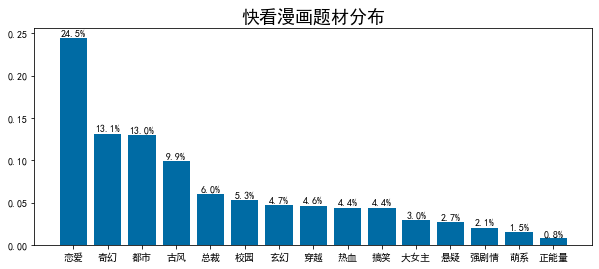

In [16]:
# 绘制柱状图
plt.figure(figsize = (10,4))
ax = plt.bar(kuaikan_tag.index, kuaikan_tag.values/kuaikan_tag.values.sum())
plt.title("快看漫画题材分布",fontsize = 18)

add_value_labels(ax,"bar")
plt.show()

可以看到，这几年流行的题材主要是恋爱、奇幻、都市、古风，作品量加起来占了整体的60%，其中恋爱题材占了整体近1/4。

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DANQIN~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.704 seconds.
Prefix dict has been built succesfully.


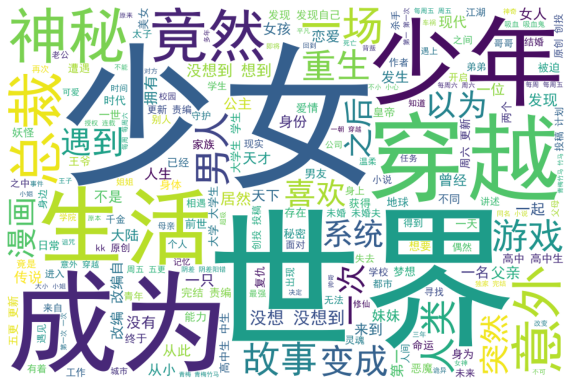

In [17]:
# 作品简介词云图
# 提取简介文字
data_txt = data_kuaikan_cn_c['description'].dropna().to_string()

# stopwords
# 哈工大停用词表可在github下载：https://github.com/goto456/stopwords
stopwords = [line.strip() for line in open("D:/02-工作学习成果/04-其它/stopwords-master/哈工大停用词表.txt",encoding="utf-8").readlines()]
    
# 分词函数
def CutWords(txt, stopwords):
    '''Cut text into words and return the list of words excluding stopwords
    :params: txt - string, txt for cutting
    :params: stopwords - list, stopwords
    :return: list of tokens'''

    result = []

    words = jieba.cut(txt, cut_all = True)
    for word in words:
        if word not in stopwords:
            result.append(word)

    return result

# 制作词云图函数
def GenWordCloud(words, w = 900 , h = 600):
    '''Return wordcloud of txt string.
    :params: words - list of tokens
    :params: w - width
    :params: h - height
    :return: wordcloud img'''

    # join the cut words into a single string
    wordstring = " ".join(words)

    # p.s. color by word frequency not available by wordcloud
    wordcloud = WordCloud(
        font_path = "simhei.ttf",
        background_color="white",
        width = w,
        height = h).generate(wordstring)

    plt.imshow(wordcloud)
    plt.axis("off")

words_txt = CutWords(data_txt, stopwords)
plt.figure(figsize=(10,8))
GenWordCloud(words_txt)

快看收录的国漫内容以讲述少年少女成长的故事居多，穿越、重生等从古早少女漫（《尼罗河女儿》等）沿用至今的题材仍然流行。以及受小说和影视剧影响，总裁类漫画也非常多。  
在这些流行题材中，真正成为大人气作品的比例有多少呢？我们先来看看全站人气Top 10的是哪些作品。

In [18]:
# Top10人气作品
data_kuaikan_cn_c.sort_values(by=["hotness"],ascending = False).head(10)

,author,title,description,hotness,kudos,last_chap,last_update,tag,is_ch
6931,※kid岁,怦然心动,少男少女同住一个屋檐下，一同历经青春的懵懂和烦恼。画风温馨的超人气少女漫，感受青春悸动的萌芽...,2.434240e+11,260426928,114 初次见面,2021-12-07,校园,国内
2499,锐思+伊凯,甜美的咬痕,多次登上每周排行榜第一名宝座！ 不可一世的血族王子，恋上卑微血仆少女。一场禁锢与占有的鼠猫...,2.424270e+11,263919799,《甜美的咬痕》单行本4来啦,2021-10-27,奇幻,国内
2404,通幽/夏天岛+叨叨君/夏天岛,捡到只小狐狸,二四特别篇上线！前世的纠葛和羁绊，在今世续缘吧！【独家/双周更（周日） 责编：33】,1.099910e+11,163058672,二四篇 特别番外,2021-09-12,奇幻,国内
4250,清英,女巨人也要谈恋爱,身高180+的软妹恋上冰山总裁。谁说女追男隔层纱？女巨人的甜虐追爱史，扑倒冰山总裁不是梦！独...,1.091000e+11,164307047,女巨人的改编小游戏上线啦~,2021-11-04,恋爱,国内
6576,妖春桥,怪奇实录,奇异事件！这些发生在你身边的故事，结局总是让人意想不到！中短篇悬疑故事合辑，喜欢反转刺激的你...,1.016810e+11,105162523,第390话 孤独者们（二）,2021-12-12,强剧情,国内
245,虹君,我男票是锦衣卫,人气古风穿越巨制，俏皮少女与傲娇锦衣卫的甜虐之恋.。上天注定的七世情缘，他转世轮回只为和她再...,8.693200e+10,146140537,橙萌喜爱 菠动心弦,2021-09-21,古风,国内
1845,兔街子（主笔）+快看漫画团队（编剧）,DOLO命运胶囊,不够漂亮也不够聪明，真的只能做最底端的人吗？如果有一种胶囊，能让你逆袭命运，你愿意付出最珍贵...,7.752000e+10,72353715,番外篇 怕上火喝王老吉,2021-08-31,奇幻,国内
4765,青庭,零分偶像,恋爱类总榜热度第一名少女漫！当红人气鲜肉被曝毕业证做假仅考零分，回大学重修遇见贫穷土鳖学霸女...,7.324000e+10,92475057,《零分偶像》广播剧上线啦！,2021-12-04,恋爱,国内
3539,壳小杀／夏天岛+左小翎／夏天岛,朝花惜时,他，戴上眼镜是沉默冷峻的高中生，摘下眼镜是浪荡不羁的夜店王子。女主同时遇上他们，想不到竟是同...,6.436800e+10,124840772,新作《成也萧河》即将上线,2018-08-21,恋爱,国内
2010,锐思+伊凯,河神大人求收养,家中突然掉下一个奇怪的陌生美男自称河神！还求我收养他！？……这个绝色美男自称是扇贝妖怪说我是...,6.371900e+10,145788035,预热 归零,2020-09-23,奇幻,国内


Top 10人气作品中，恋爱、奇幻题材居多，另有一部强剧情题材的作品脱颖而出。从内容简介看，总裁、穿越等关键词也出现了。这些爆火的作品或许在某种程度上也指引了其它漫画作者的创作方向，从而形成了这种特定的流行趋势。 

为了统计各题材中大人气作品的比例，我们首先要对多少人气值算是大人气设定一个门槛。

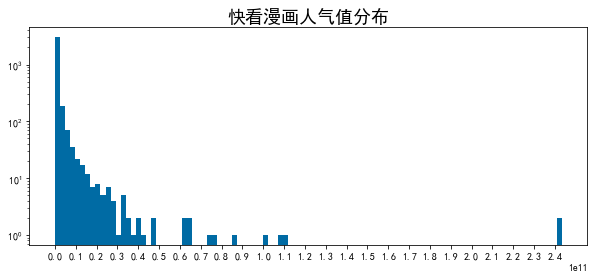

In [19]:
# 查看各题材中大人气作品比例
# 首先为了划分大人气的门槛，查看整体人气值分布
# 绘制直方图
plt.figure(figsize = (10,4))
plt.hist(data_kuaikan_cn_c.hotness,100,log = True)
plt.title("快看漫画人气值分布",fontsize = 18)
plt.xticks(np.arange(0, data_kuaikan_cn_c.hotness.max()+1, 10**10))
plt.show()

可以看到，大部分作品人气都在20亿以下，我们暂时以20亿为界，给各作品打标签。

c:\users\dan qin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


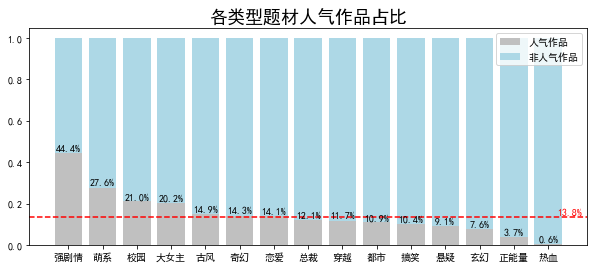

In [20]:
# 对人气是否大于20亿打标签：第一个数据集用于计算整体人气作品占比，作为参照基线；第二个用于计算分题材占比
data_kuaikan_cn_c["is_hot"] = [1 if x > 2*(10**9) else 0 for x in data_kuaikan_cn_c["hotness"]]
data_kuaikan_cn["is_hot"] = [1 if x > 2*(10**9) else 0 for x in data_kuaikan_cn["hotness"]]

# 计算整体人气作品占比
total_ratio = len(data_kuaikan_cn_c[data_kuaikan_cn_c.is_hot == 1].index)/len(data_kuaikan_cn_c.index)

# 计算分题材人气作品占比
bar_plot = data_kuaikan_cn.groupby(["tag","is_hot"]).size().unstack(fill_value=0)
# 计算百分比
bar_plot = bar_plot.apply(lambda x: x/x.sum(), axis=1).reset_index().sort_values(by=[1],ascending=False)

# 绘制堆叠柱状图
plt.figure(figsize=(10,4))
ax1 = plt.bar(bar_plot["tag"], bar_plot[1], color='silver')
ax2 = plt.bar(bar_plot["tag"], bar_plot[0], bottom=bar_plot[1], color='lightblue')
plt.legend(["人气作品","非人气作品"])
plt.axhline(y=total_ratio, color='r', linestyle='--') # 基线：整体人气作品占比
plt.text(len(bar_plot.index),total_ratio, "{}%".format(round(total_ratio*100,1)), color="red", 
        ha="right", va="bottom")

add_value_labels(ax1,"bar")
plt.title("各类型题材人气作品占比",fontsize = 18)
plt.show()

作品量Top 4的恋爱、奇幻、都市、古风题材中，大人气作品占比大约都在14%左右，古风稍高在14.9%，都市最低在10.9%。作品量较少的强剧情、萌系和大女主题材，人气作品的比例倒是很高。可见剧情向的漫画还是很受欢迎。

##### 2.1.2 趋势
快看App 2014年上架，大概在随后几年国内资本开始进驻动漫圈，许多互联网漫画平台纷纷兴起，国产漫画作品数量激增。经过这么多年的发展，现在这样的高增长趋势是否还在继续保持呢？  
我们可以通过统计每年完结作品量，来大致感受下国产漫画市场规模的变化。

c:\users\dan qin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\dan qin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


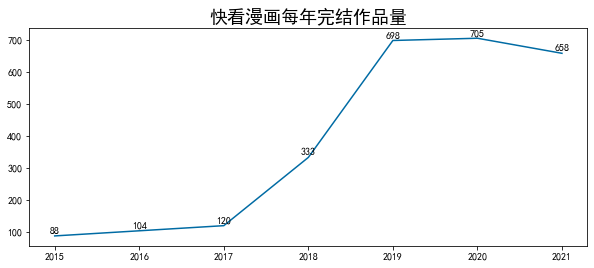

In [21]:
# 2021年作品近一个月没更新的视为已完结状态，否则视为仍在连载中
data_kuaikan_cn_c["status"] = ["已完结" if x < dt.datetime(2021,11,15) else "连载中" for x in data_kuaikan_cn_c["last_update"]]

# 提取最后更新年份
data_kuaikan_cn_c["last_up_year"] = data_kuaikan_cn_c.last_update.dt.year

# 统计每年完结作品量
end_cnt = data_kuaikan_cn_c[data_kuaikan_cn_c["status"]=="已完结"]["last_up_year"].value_counts().sort_index()

# 绘制趋势图
plt.figure(figsize=(10,4))
ax = plt.plot(end_cnt.index, end_cnt.values)
plt.title("快看漫画每年完结作品量",fontsize = 18)
add_value_labels(ax,"line")
plt.show()

经过2017-2019年的爆发式增长，2019年以后国产漫画的作品年产量似乎已经开始进入稳定期，每年完结的作品量维持在700部左右。  
接下来再看看流行题材的变化趋势。

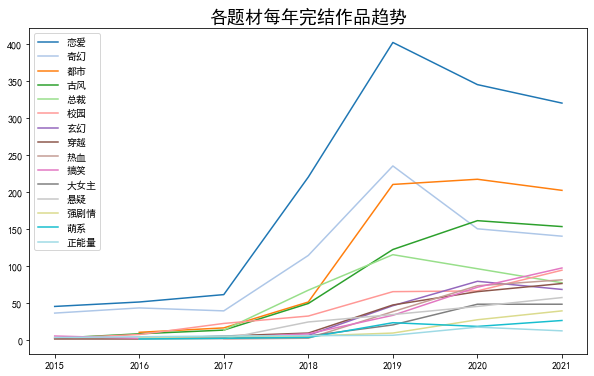

In [22]:
# 提取连载状态和最后更新年份
data_kuaikan_cn["status"] = ["已完结" if x < dt.datetime(2021,11,15) else "连载中" for x in data_kuaikan_cn["last_update"]]
data_kuaikan_cn["last_up_year"] = data_kuaikan_cn.last_update.dt.year

# 绘制趋势图
plt.figure(figsize=(10,6))
tags = data_kuaikan_cn.tag.value_counts().sort_values(ascending=False).index
colors = plt.cm.tab20(np.linspace(0, 1, len(tags)))

for i in range(len(tags)):
    # 统计每年完结作品量
    tag = tags[i]
    tmp = data_kuaikan_cn[data_kuaikan_cn["tag"] == tag]
    end_cnt = tmp[tmp["status"]=="已完结"]["last_up_year"].value_counts().sort_index()
    ax = plt.plot(end_cnt.index, end_cnt.values, label = tag, color = colors[i])


plt.title("各题材每年完结作品趋势",fontsize = 18)
plt.legend()

恋爱、奇幻、总裁类题材的作品近两年明显减少了，都市、古风等题材的作品量也趋于稳定。强剧情、大女主、搞笑、热血、穿越等题材倒是在19年后作品量呈现了明显的上升趋势。国漫的内容或许会朝向越来越多元的方向发展。

最后我们再看看仍在连载中的作品情况。

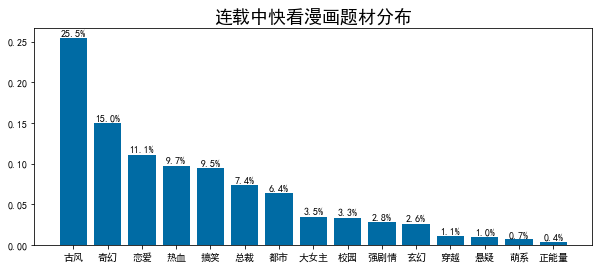

In [23]:
tag_tbc = data_kuaikan_cn_c[data_kuaikan_cn_c["status"]=="连载中"].tag.value_counts()

# 绘制柱状图
plt.figure(figsize = (10,4))
ax = plt.bar(tag_tbc.index, tag_tbc.values/tag_tbc.values.sum())
plt.title("连载中快看漫画题材分布",fontsize = 18)

add_value_labels(ax,"bar")
plt.show()

恋爱、都市题材的占比已经大幅下降，搞笑、热血向作品的比例升高了，古风成为了新的流行趋势。

##### 2.1.3 对比日漫
在国漫和韩漫盛行之前，国内的漫画读者阅读范围仍以日漫居多，因此我们也与日漫的数据做对比，看看国漫与日漫在题材上有哪些不同，国漫在哪些题材上还有发展潜力。

In [24]:
# 题材分布：dmzj一部作品对应多个题材tag，把它们拆为多行
# 复制一份数据集
data_dmzj_c = data_dmzj
data_dmzj_c["tag"] = data_dmzj_c["tag"].str.split()
data_dmzj_c = data_dmzj_c.explode("tag")

data_dmzj_c.head(3)

,title,author,category,area,status,tag,last_chap,last_update,description,hit_num,hot_num,sub_num,vote_num
0,kanon & AIR,石原立也 桂游生丸,少年漫画,日本,已完结,爱情,14话,2007-05-03,\n kanon & AIR漫画 ，kanon & AIR欢迎...,1989334,1454870,6725,37
0,kanon & AIR,石原立也 桂游生丸,少年漫画,日本,已完结,生活,14话,2007-05-03,\n kanon & AIR漫画 ，kanon & AIR欢迎...,1989334,1454870,6725,37
0,kanon & AIR,石原立也 桂游生丸,少年漫画,日本,已完结,萌系,14话,2007-05-03,\n kanon & AIR漫画 ，kanon & AIR欢迎...,1989334,1454870,6725,37


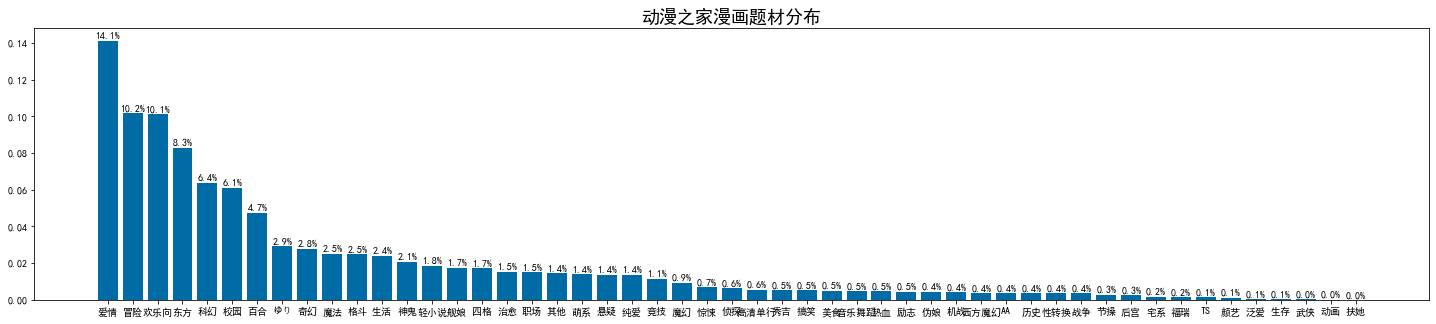

In [25]:
# 绘制柱状图
dmzj_tag = data_dmzj_c.tag.value_counts()

plt.figure(figsize = (25,5))
ax = plt.bar(dmzj_tag.index, dmzj_tag.values/dmzj_tag.values.sum())
plt.title("动漫之家漫画题材分布",fontsize = 18)

add_value_labels(ax,"bar")
plt.show()

动漫之家的分类比较繁杂，但仍能看出恋爱、冒险、搞笑向的作品是最多的。其次是东方同人向作品、科幻、校园和百合题材，加总占到总体的70%。

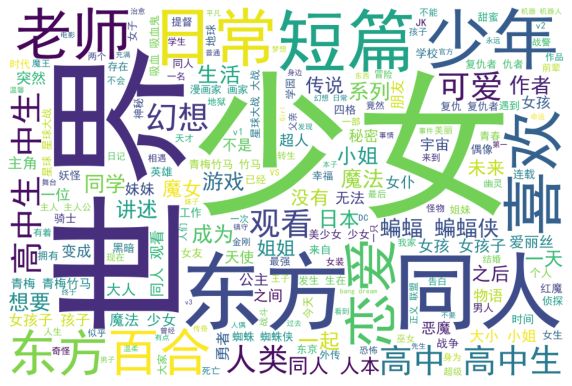

In [26]:
# 作品简介词云图
# 提取简介文字
data_txt = data_dmzj['description'].dropna().to_string()

# 自定义stopwords
stp_wrds = ["动漫","之家","漫画","欢迎","漫画网","故事"]
for wrd in stp_wrds:
    stopwords.append(wrd)

words_txt = CutWords(data_txt, stopwords)
plt.figure(figsize=(10,8))
GenWordCloud(words_txt)

In [27]:
# Top10人气作品
data_dmzj.sort_values(by=["hot_num"],ascending = False).head(10)

,title,author,category,area,status,tag,last_chap,last_update,description,hit_num,hot_num,sub_num,vote_num
22120,别当欧尼酱了！,ねことうふ（猫豆腐）,少年漫画,日本,连载中,"[欢乐向, TS]",第57话,2021-11-28,\n 别当欧尼酱了！漫画 ，一觉醒来，家里蹲变成了萌萝莉？！ ...,114952552,111471918,462425,59736
29297,久保同学不放过我,雪森宁宁,少年漫画,日本,连载中,"[爱情, 校园]",第91话,2021-11-28,\n 久保同学不放过我漫画 ，人都忽视了你，我也能将你找出来。...,80105764,106302101,393491,25766
9619,狂赌之渊,尚村透 河本ほむら,青年漫画,日本,连载中,"[校园, 颜艺]",第89话下,2021-11-23,\n 狂赌之渊漫画 ，私立百花王学园，一所以培养学生战术策略、...,624541776,95716720,442604,33087
20553,再见龙生你好人生,くろの 永岛ひろあき,少年漫画,日本,连载中,"[冒险, 泛爱, 轻小说]",第61话,2021-09-23,\n 再见龙生你好人生漫画 ，上古神龙被曾经一起战斗的人类伙伴...,128933406,94322885,412281,17988
27032,东京复仇者,和久井健,少年漫画,日本,连载中,"[冒险, 格斗]",第232话,2021-11-28,\n 东京复仇者漫画 ，主角武道做什么事情都不顺，又住在破旧老...,485854104,93392880,306893,42709
27541,被勇者队伍开除的驭兽使、邂逅了最强种的猫耳少女,茂村モト 深山铃,少年漫画,日本,连载中,"[冒险, 奇幻, 轻小说]",第53话,2021-11-14,\n 被勇者队伍开除的驭兽使、邂逅了最强种的猫耳少女漫画 ，被...,86465867,90474427,372288,17950
24076,不熟练的两人,カワハラ恋,少年漫画,日本,连载中,"[欢乐向, 爱情]",第76话,2021-11-23,\n 不熟练的两人漫画 ，如果娶了个高冷（伪）妻子，新婚生活会...,60982581,86857898,356492,18077
20820,完全没有恋爱感情的青梅竹马,亘井,少年漫画,日本,连载中,"[爱情, 校园]",连载45话,2021-11-14,\n 完全没有恋爱感情的青梅竹马漫画 ，如果这不是恋爱，那就是...,64898401,86553165,430855,31269
25634,勇者辞职不干了,风都野丽(风都ノリ) クオンタム,少年漫画,日本,连载中,"[冒险, 轻小说]",第27话,2021-09-07,\n 勇者辞职不干了漫画 ，靠一己之力，独自击败了魔王军四天王...,72997485,81528253,329547,6046
21173,为了女儿击倒魔王,はた。 chirolu,少年漫画,日本,连载中,"[冒险, 魔法]",番外07,2021-07-30,\n 为了女儿击倒魔王漫画 ，以高超的战斗技巧和冷静的判断力为...,63518763,81507366,391315,15414


日漫的故事主角也以少年、少女为主，高中生和日常类题材尤为常见。人气Top10的作品基本上都是讲述青少年的冒险和恋爱故事的少年漫画。  
同样，我们也看下日漫各题材中大人气作品的比例。

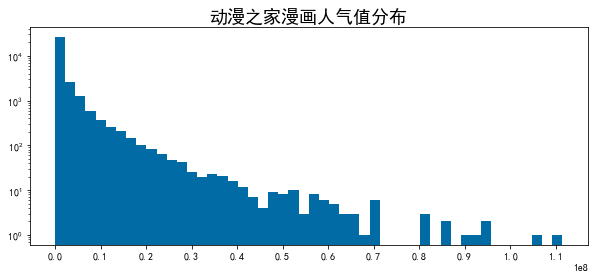

In [28]:
# 查看dmzj人气值分布
plt.figure(figsize = (10,4))
plt.hist(data_dmzj.hot_num,50, log = True)
plt.title("动漫之家漫画人气值分布",fontsize = 18)
plt.xticks(np.arange(0, data_dmzj.hot_num.max()+1,10**7))
plt.show()

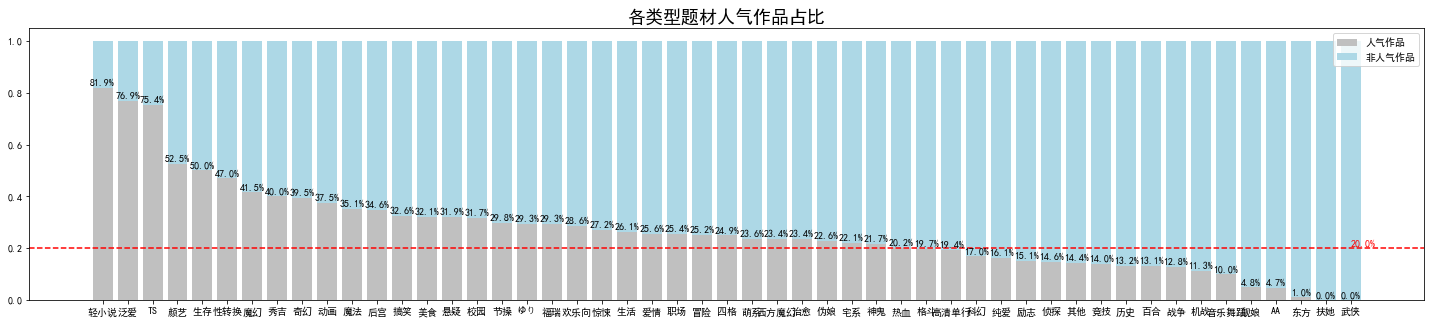

In [29]:
# dmzj作品人气多在200万以下，对人气是否大于200万打标签
data_dmzj_c["is_hot"] = [1 if x > 2*(10**6) else 0 for x in data_dmzj_c["hot_num"]]
data_dmzj["is_hot"] = [1 if x > 2*(10**6) else 0 for x in data_dmzj["hot_num"]]

# 计算整体人气作品占比
total_ratio = len(data_dmzj[data_dmzj.is_hot == 1].index)/len(data_dmzj.index)

# 计算分题材人气作品占比：分组计数
bar_plot = data_dmzj_c.groupby(["tag","is_hot"]).size().unstack(fill_value=0)
# 计算百分比
bar_plot = bar_plot.apply(lambda x: x/x.sum(), axis=1).reset_index().sort_values(by=[1],ascending=False)

# 绘制堆叠柱状图
plt.figure(figsize=(25,5))
ax1 = plt.bar(bar_plot["tag"], bar_plot[1], color='silver')
ax2 = plt.bar(bar_plot["tag"], bar_plot[0], bottom=bar_plot[1], color='lightblue')
plt.legend(["人气作品","非人气作品"])
plt.axhline(y=total_ratio, color='r', linestyle='--') # 基线：整体人气作品占比
plt.text(len(bar_plot.index),total_ratio, "{}%".format(round(total_ratio*100,0)), color="red", 
        ha="right", va="bottom")

add_value_labels(ax1,"bar")
plt.title("各类型题材人气作品占比",fontsize = 18)
plt.show()

轻小说漫改、后宫和性转题材里大人气作品的比例是最高的，远远甩开了其它分类。可以看出动漫之家读者的偏好中显示出了明显的宅倾向。  
再来对比下连载中作品的情况。

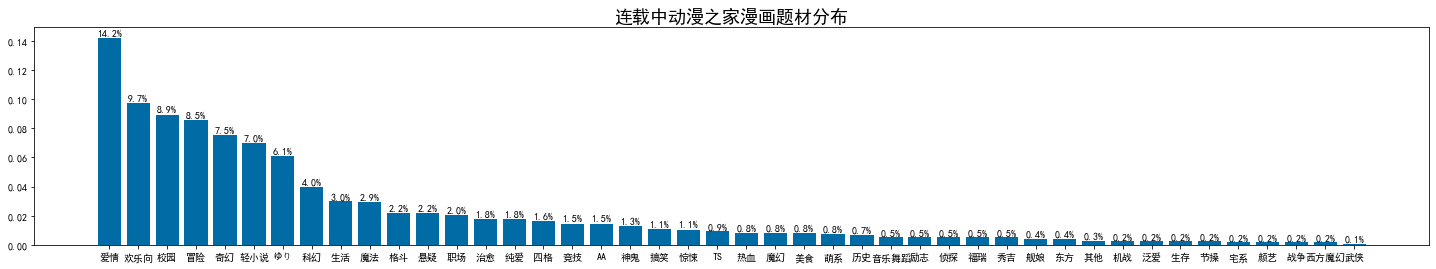

In [30]:
# 由于dmzj的作品多为汉化组或同好上传，会存在作品实际已完结而许久未更新的状态
# 只取最后更新时间在近三个月内，且状态为“连载中”的作品
tag_tbc = data_dmzj_c[(data_dmzj_c["last_update"]>dt.datetime(2021,11,15)) & (data_dmzj_c["status"]=="连载中")].tag.value_counts()

# 绘制柱状图
plt.figure(figsize = (25,4))
ax = plt.bar(tag_tbc.index, tag_tbc.values/tag_tbc.values.sum())
plt.title("连载中动漫之家漫画题材分布",fontsize = 18)

add_value_labels(ax,"bar")
plt.show()

恋爱、搞笑、校园、冒险类题材仍是王道，同时轻小说漫改作品的比例大大增加。近两年国产漫画中也出现了许多小说漫改作，这个趋势是一致的。不管是日本还是中国，都越来越重视挖掘ip的价值。

#### 2.2 国产漫画现状：作者篇

分析完作品，再来从创作者角度分析。在日本，漫画多是以漫画家为故事和画面创作主力，再辅以助理协助背景作画和网点、涂黑等工作。虽然也有原作+作画的合作模式（比如著名的大场与小畑健组合），个人创作者为主的形式仍更多见。而国产漫画自登上互联网平台以后，在作画和更新频率要求上与日漫产生了许多不同（彩色画面，一周双更等），个人作者往往很难独立完成，漫画工作室的创作形式应运而生，编剧、主笔、勾线、上色等工作由多人分工完成。

* 个人作者 vs 工作室：当前国漫创作哪种模式用得更多？比起早几年漫画工作室井喷式的发展，现在是否已经开始收敛？

In [31]:
# 只看作者，所以需要剔除重复数据
data_kuaikan_ch_c = data_kuaikan_ch.drop_duplicates(subset = ["author","title"])

# 区分个人作者与工作室：名字包含（动漫,漫画,工作室,社,映画,文化,工厂），或带“+”的多人合作，均标记为“工作室”
data_kuaikan_ch_c["author_type"] = np.where(data_kuaikan_ch_c['author'].str.contains("动漫|漫画|工作室|社|映画|文化|工厂|\+",regex=True),
                                          '工作室', '个人作者')

c:\users\dan qin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


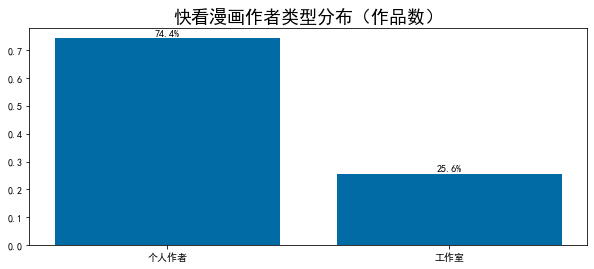

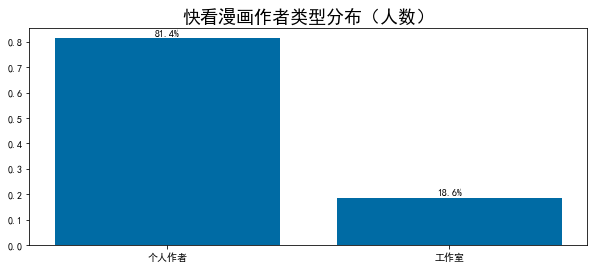

In [32]:
# 查看个人作者vs工作室占比 - 作品数
tag = data_kuaikan_ch_c.author_type.value_counts()

plt.figure(figsize = (10,4))
ax = plt.bar(tag.index, tag.values/tag.values.sum())
plt.title("快看漫画作者类型分布（作品数）",fontsize = 18)

add_value_labels(ax,"bar")
plt.show()

# 查看个人作者vs工作室占比 - 作者人数
authors = data_kuaikan_ch_c.groupby("author_type").nunique()

plt.figure(figsize = (10,4))
ax = plt.bar(authors.index, authors.author/authors.author.sum())
plt.title("快看漫画作者类型分布（人数）",fontsize = 18)

add_value_labels(ax,"bar")
plt.show()

近80%的创作者仍是个人作者，工作室/多人合作占了作者人数的19%，但创作了近26%的作品。

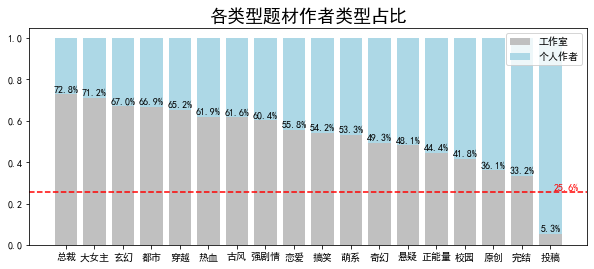

In [33]:
# 计算分题材作者类型占比：分组计数
data_kuaikan_ch["author_type"] = np.where(data_kuaikan_ch['author'].str.contains("动漫|漫画|工作室|社|映画|文化|工厂|\+",regex=True),
                                          '工作室', '个人作者')
bar_plot = data_kuaikan_ch.groupby(["tag","author_type"]).size().unstack(fill_value=0)

# 整体工作室占比
total_ratio = len(data_kuaikan_ch_c[data_kuaikan_ch_c.author_type == "工作室"].index)/len(data_kuaikan_ch_c.index)

# 计算百分比
bar_plot = bar_plot.apply(lambda x: x/x.sum(), axis=1).reset_index().sort_values(by=["工作室"],ascending=False)

# 绘制堆叠柱状图
plt.figure(figsize=(10,4))
ax1 = plt.bar(bar_plot["tag"], bar_plot["工作室"], color='silver')
ax2 = plt.bar(bar_plot["tag"], bar_plot["个人作者"], bottom=bar_plot["工作室"], color='lightblue')
plt.legend(["工作室","个人作者"])
plt.axhline(y=total_ratio, color='r', linestyle='--') # 基线：整体人气作品占比
plt.text(len(bar_plot.index),total_ratio, "{}%".format(round(total_ratio*100,1)), color="red", 
        ha="right", va="bottom")

add_value_labels(ax1,"bar")
plt.title("各类型题材作者类型占比",fontsize = 18)
plt.show()

分题材来看就可以发现，大部分的个人作者的作品都集中在近两年开始的原创征稿项目里，其它分类作品多为工作室创作。再来看看趋势是否能作证这一观点。

c:\users\dan qin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


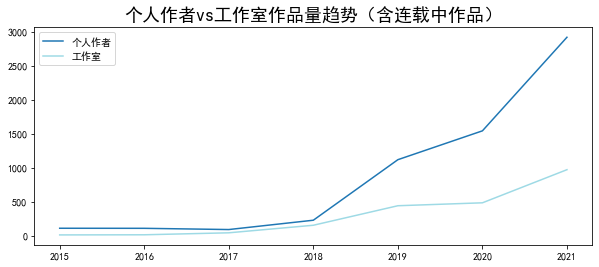

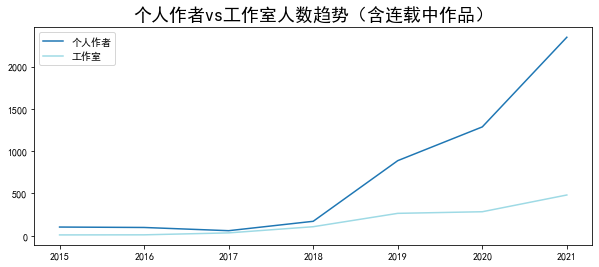

In [34]:
# 提取最后更新年份
data_kuaikan_ch_c["last_up_year"] = data_kuaikan_ch_c.last_update.dt.year

# 绘制趋势图 - 作品量
plt.figure(figsize=(10,4))
types = data_kuaikan_ch_c.author_type.value_counts().sort_values(ascending=False).index
colors = plt.cm.tab20(np.linspace(0, 1, len(types)))

for i in range(len(types)):
    # 统计每年完结作品量
    author_type = types[i]
    tmp = data_kuaikan_ch_c[data_kuaikan_ch_c["author_type"] == author_type]
    cnt = tmp["last_up_year"].value_counts().sort_index()
    ax = plt.plot(cnt.index, cnt.values, label = author_type, color = colors[i])

plt.title("个人作者vs工作室作品量趋势（含连载中作品）",fontsize = 18)
plt.legend()

# 绘制趋势图 - 作者人数
plt.figure(figsize=(10,4))
authors = data_kuaikan_ch_c.groupby("last_up_year").nunique()

for i in range(len(types)):
    # 统计每年完结作品量
    author_type = types[i]
    tmp = data_kuaikan_ch_c[data_kuaikan_ch_c["author_type"] == author_type].groupby("last_up_year").nunique()
    ax = plt.plot(tmp.index, tmp.author, label = author_type, color = colors[i])

plt.title("个人作者vs工作室人数趋势（含连载中作品）",fontsize = 18)
plt.legend()

在2019年以前，个人作者与工作室人数和作品量基本持平，2019年以后个人作者投稿量激增，到2021年达到了3000部。同时，漫画工作室的数量明显开始趋于平稳。

### 3. 结论总结

总结一下，在报告开头我们提出了几个问题。以下是从数据分析中得到的一些结论：  
与以少年漫画为主力的日漫不同，当前国漫市场更偏女性向，恋爱、耽美向的作品更多，都市、总裁类题材的少女漫也屡见不鲜，古风、玄幻等我国特有的题材类型也很受欢迎。不过近年国漫也在往越来越多元化的方向发展，开始出现更多搞笑、热血向的漫画。比起早年漫画工作室撑起国漫半边天的景象，近两年越来越多的个人创作者开始投入商业化漫画的市场。

由于数据来源的问题，本分析报告的结论总不免有失偏颇，毕竟各家漫画平台在定位上各有不同。本分析仅仅作为参考。

### 4. 延伸探索：寻找冷门高分作品

正文的分析到这里就结束了。后面是一些个人感兴趣的延伸探索。

这里以动漫之家的数据为例，来探索下有哪些冷门高分的作品。由于没有从网站中采集到各作品的评分数据，这里就用别的指标来衡量读者对作品的评价。动漫之家没有公布其人气值的统计规则，但大体上是点击、订阅、评论的综合。所以我们就用用人气值/点击量、订阅数/点击量来简单模拟作品的评分。

In [3]:
# 排除点击量小于订阅量的异常数据
data_dmzj_n = data_dmzj[data_dmzj["hit_num"]>data_dmzj["sub_num"]].copy()

# 计算人气值/点击量、订阅数/点击量
data_dmzj_n["hot_hit"] = data_dmzj_n["hot_num"]/data_dmzj_n["hit_num"]
data_dmzj_n["sub_hit"] = data_dmzj_n["sub_num"]/data_dmzj_n["hit_num"]

# 把人气值/点击量归一到(0,1)范围
data_dmzj_n["hot_hit"] = (data_dmzj_n.hot_hit-data_dmzj_n.hot_hit.min())/(data_dmzj_n.hot_hit.max()-data_dmzj_n.hot_hit.min())

In [12]:
# 查看高评分作品
rank_high = data_dmzj_n[data_dmzj_n["description"].str.contains("短篇",na=False)].sort_values(by=["sub_hit","hot_hit"],ascending = False)
rank_high.head(10)

,description,hit_num,hot_num,sub_num,title,vote_num,作者,分类,别名,原名,地域,最新收录,状态,题材,hot_hit,sub_hit
27201,\n 我所在的街道摇晃着漫画 ，2016年4月熊本地震，实地取...,2881,455132,2075,我所在的街道摇晃着,5,松岡佳范,少年漫画,NaN,NaN,日本,短篇 2019-03-26,已完结,生活,0.461116,0.720236
26337,\n 街角魔族短篇漫画 ，街角魔族同人短篇欢迎在动漫之家漫画网...,2482,349218,1570,街角魔族短篇,18,Beize,少年漫画,NaN,NaN,日本,短篇 2021-02-23,已完结,ゆり,0.410685,0.632554
27112,\n 小太妹真伪莫辨的真相漫画 ，小太妹发现了真相！（虽然真伪...,8260,1139536,5204,小太妹真伪莫辨的真相,22,石黑正数,少年漫画,ヤンキ嬢ちやんの不確かな真実,NaN,日本,第02话 2019-03-13,连载中,校园 生活,0.402682,0.630024
14928,\n 星球大战：毒月漫画 ，星球大战骷髅岛小短篇欢迎在动漫之家...,365,69893,229,星球大战：毒月,0,Dark Horse Comics,少年漫画,NaN,NaN,欧美,短篇 2020-08-31,已完结,科幻,0.558933,0.627397
28393,\n 再见-欢迎回来漫画 ，文椛短篇欢迎在动漫之家漫画网观看再...,410,45460,225,再见-欢迎回来,2,いろいろゃる人,少年漫画,NaN,NaN,日本,短篇 2019-08-09,已完结,东方,0.323635,0.548780
28580,\n 冷酷女子与直脑筋男子漫画 ，加藤雄一老师在p站画的短篇欢...,17819,1597287,9324,冷酷女子与直脑筋男子,35,加藤雄一,少年漫画,NaN,NaN,日本,第01-02话 2019-08-24,连载中,其他,0.261640,0.523262
26484,\n 不良与风纪委员的故事漫画 ，みかん氏的p站百合短篇欢迎在...,24275,2511186,11091,不良与风纪委员的故事,42,みかん氏,少年漫画,NaN,ヤンキーと風紀委員のお話,日本,第01话 2018-12-20,已完结,百合,0.301945,0.456890
15048,\n NOMAN×孤独怪物漫画 ，孤独怪物与盲少女和Dear ...,4677,641818,2129,NOMAN×孤独怪物,5,寝路,少年漫画,NaN,NaN,日本,第01话 2020-09-07,已完结,其他,0.400551,0.455206
25349,\n 女子高生百合漫画 ，もちオーレ老师的推特短篇，别扭妹和乐...,23014,2346171,10011,女子高生百合,34,もちオーレ,少年漫画,NaN,NaN,日本,第01话 2018-08-18,连载中,百合,0.297561,0.434996
25932,\n 在酉京都似乎非常流行万圣节漫画 ，万圣节秘封组甜到腻短篇...,4907,497318,1956,在酉京都似乎非常流行万圣节,8,べにしゃけ,少年漫画,NaN,NaN,日本,短篇 2018-11-03,已完结,百合 东方,0.295819,0.398614


In [15]:
rank_high.to_csv("data/rank_high.csv",encoding="utf-8-sig")

In [37]:
# 将notebook保存为html
!jupyter nbconvert MangaAnalysis.ipynb --to html

[NbConvertApp] Converting notebook MangaAnalysis.ipynb to html
[NbConvertApp] Writing 1554804 bytes to MangaAnalysis.html
